In [ ]:
%%capture
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan

In [ ]:
import pickle, re, ast, scipy, umap, hdbscan
import numpy as np
import pandas as pd
import copy as cp
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from tqdm import tqdm
from scipy.stats import entropy
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import mixture
from sklearn.decomposition import PCA
from matplotlib_venn import venn3

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Knowledge\ Graphs\ 2022/

/content/drive/.shortcut-targets-by-id/18wZgIc4f2VuuQ34uv_vRrBAOHvMWSEaq/Knowledge Graphs 2022


In [ ]:
all_tweets_df = pd.read_csv('data/tweets_cleaned_sentence.csv')
all_tweets_df = all_tweets_df.fillna('')
all_tweets_df

,id,text,time,user_id,user_screen_name,cleaned_text
0,1420959115879145474,https://t.co/3bM9PoSxS6 #acoustic #orchestra #...,Fri Jul 30 04:07:08 +0000 2021,1404563992907976706,teknoaxe,
1,1420589578541428739,@DekeSlade Hey Rj! A link to my youtube chann...,Thu Jul 29 03:38:43 +0000 2021,1404563992907976706,teknoaxe,Hey Rj! A link to my youtube channel or the v...
2,1420533067400105985,@kraftoki @MinxMore How do you know?,Wed Jul 28 23:54:10 +0000 2021,1404563992907976706,teknoaxe,How do you know?
3,1420373718828679174,"@MinxMore Also, consider that ""immune for only...",Wed Jul 28 13:20:58 +0000 2021,1404563992907976706,teknoaxe,"Also, consider that immune for only a few mont..."
4,1420373378653773829,@MinxMore It's like chicken pox....,Wed Jul 28 13:19:37 +0000 2021,1404563992907976706,teknoaxe,Its like chicken pox....
...,...,...,...,...,...,...
923380,1397974274367963136,@Baklava_in_CA @jordanbpeterson I got my pound.,Thu May 27 17:53:34 +0000 2021,218741203,mml111mml111,I got my pound.
923381,1397972983067693064,@nypost He tries to turn his hotel rooms into ...,Thu May 27 17:48:26 +0000 2021,218741203,mml111mml111,He tries to turn his hotel rooms into Vermont?
923382,1397972391708475392,@Baklava_in_CA @jordanbpeterson I've realized ...,Thu May 27 17:46:05 +0000 2021,218741203,mml111mml111,Ive realized we are never going to pay that de...
923383,1397813255523995648,"So, what do you think the long term side effec...",Thu May 27 07:13:44 +0000 2021,218741203,mml111mml111,"So, what do you think the long term side effec..."


In [ ]:
all_users = list(set(all_tweets_df['user_id'].tolist()))
accounts_dict = {}
for k in all_users:
    accounts_dict[k] = all_tweets_df[all_tweets_df['user_id'] == k]['cleaned_text'].tolist()

### Sentiment Varaince

In [ ]:
sentiment_scores=pd.read_csv('data/df_tweets_sentiment_scores.csv')
sentiment_dict = {}
for k in all_users:
  sentiment_dict[k] = sentiment_scores[sentiment_scores['user_id'] == k]['sentiment_score'].tolist()

sentiment_variance_dict = {}
for k in tqdm(accounts_dict.keys(), total=len(all_users)):
  sentiment_vector = sentiment_dict[k]
  sentiment_variance_dict[k] = np.var(sentiment_vector)

100%|██████████| 12246/12246 [00:00<00:00, 33472.15it/s]


### Sentence Embeddings

In [ ]:
sentence = ["example sentence"]

model = SentenceTransformer('sentence-transformers/sentence-t5-base')
embeddings = model.encode(sentence)
print(embeddings)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/198 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/219M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

[[-0.01504607  0.02145201  0.01706478  0.01872689  0.00414228 -0.01891462
  -0.02198385  0.08006198 -0.02841545 -0.02460875  0.02037823 -0.06108064
   0.06203061  0.02518949  0.05970793  0.04386357  0.01046984 -0.02730115
   0.05052985  0.04059158  0.0516929  -0.04583651 -0.00436275  0.00487236
  -0.02169147  0.03611296  0.03472493 -0.01096235 -0.00594312  0.00158183
   0.08155333 -0.04372063 -0.04358909  0.04860363 -0.01874361  0.01784375
  -0.05378539 -0.02879451 -0.04266805 -0.00384174  0.00482855 -0.069243
  -0.05171344  0.06232771 -0.0390332  -0.03366848 -0.0064943   0.06984081
   0.00318728 -0.06988004 -0.047662   -0.02643621 -0.03936544 -0.04610877
  -0.04809608 -0.02219038 -0.04667166  0.03064915  0.0145607  -0.00345194
  -0.08529638  0.03002329  0.00493852 -0.02120291 -0.05677139  0.01892552
  -0.03706561 -0.08132117  0.03923859  0.03291112  0.03994935 -0.01574207
  -0.02900602 -0.03679398 -0.03388183 -0.01575533 -0.02895968  0.02308117
   0.08694185 -0.00293615  0.00386913 -0

In [ ]:
# https://stats.stackexchange.com/questions/239059/similarity-metrics-for-more-than-two-vectors
def sentence_similarity(docs):
  try:
    concat_embeddings = np.array(model.encode(docs)).T
    n_tweets = len(docs)
    u, s, vh = scipy.linalg.svd(concat_embeddings)
    return s[0]**2/n_tweets
  except:
    return 1

In [ ]:
sentence_similarity_dict = {}
for k in tqdm(accounts_dict.keys(), total=len(all_users)):
  docs = accounts_dict[k]
  sentence_similarity_dict[k] = sentence_similarity(docs)

100%|██████████| 12246/12246 [22:44<00:00,  8.98it/s]


## Distribution of different features

In [ ]:
sentence_similarity_list = []
sentiment_variance_list = []

for k in tqdm(accounts_dict.keys(), total=len(all_users)):
  sentence_similarity_list.append(sentence_similarity_dict[k])
  sentiment_variance_list.append(sentiment_variance_dict[k])

accounts_df = pd.DataFrame.from_dict({"user_id": list(accounts_dict.keys()), 
       "sentence_similarity": sentence_similarity_list,
       "sentiment_variance": sentiment_variance_list})

# CHECKPOINT
accounts_info_file_path = 'bot detection/user_features.csv'
accounts_df.to_csv(accounts_info_file_path, index=False)
accounts_df = pd.read_csv(accounts_info_file_path)
accounts_df

100%|██████████| 12246/12246 [00:00<00:00, 978985.38it/s]


,user_id,sentence_similarity,sentiment_variance
0,776662695454146560,0.732212,0.201977
1,1043695347355156480,1.000000,0.000000
2,948700168609726466,0.765969,0.096375
3,1308558462150901763,1.000000,0.000000
4,848593838721597443,0.748565,0.104291
...,...,...,...
12241,176521190,0.711220,0.287295
12242,609091574,0.737362,0.143860
12243,2392686584,0.712778,0.211979
12244,107216890,1.000000,0.000000


In [ ]:
data = accounts_df.filter(items=['sentence_similarity', 'sentiment_variance']).to_numpy()
data.shape

(12246, 2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdc4d09350>]],
      dtype=object)

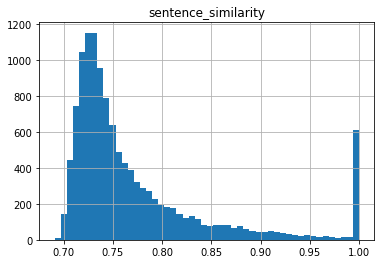

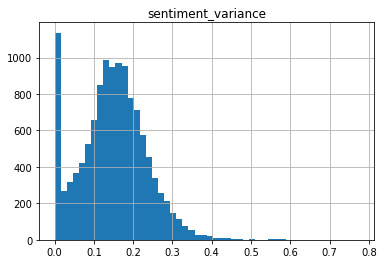

In [ ]:
accounts_df.hist(column="sentence_similarity", bins=50)
accounts_df.hist(column="sentiment_variance", bins=50)

## Clustering

(array([1.136e+03, 2.660e+02, 3.150e+02, 3.670e+02, 4.230e+02, 5.250e+02,
        6.560e+02, 8.470e+02, 9.870e+02, 9.470e+02, 9.700e+02, 9.550e+02,
        7.770e+02, 7.130e+02, 5.760e+02, 4.520e+02, 3.390e+02, 2.580e+02,
        2.140e+02, 1.470e+02, 1.160e+02, 7.600e+01, 5.300e+01, 2.700e+01,
        2.700e+01, 2.100e+01, 1.000e+01, 1.100e+01, 8.000e+00, 5.000e+00,
        6.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.73633263, -1.55450205, -1.37267146, -1.19084088, -1.0090103 ,
        -0.82717971, -0.64534913, -0.46351855, -0.28168796, -0.09985738,
         0.0819732 ,  0.26380379,  0.44563437,  0.62746495,  0.80929554,
         0.99112612,  1.1729567 ,  1.35478729,  1.53661787,  1.71844845,
         1.90027904,  2.08210962,  2.2639402 ,  2.44577079,  2.62760137,
         2.

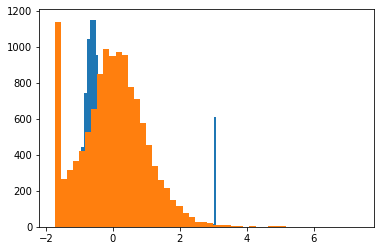

In [ ]:
reducer = umap.UMAP(random_state=42)
scaled_data = StandardScaler().fit_transform(data)
embedding = reducer.fit_transform(scaled_data)

user_ids = accounts_df['user_id'].tolist()
n_users = len(user_ids)

plt.hist(scaled_data[:, 0], bins=50)
plt.hist(scaled_data[:, 1], bins=50)

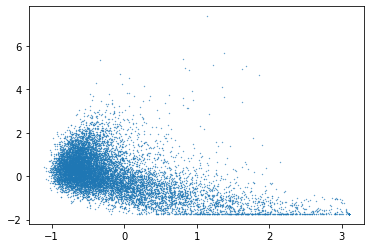

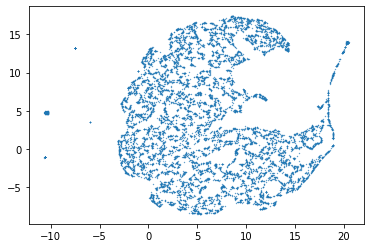

In [ ]:
plt.figure()
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], s=0.1, cmap='Spectral')
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')

1600


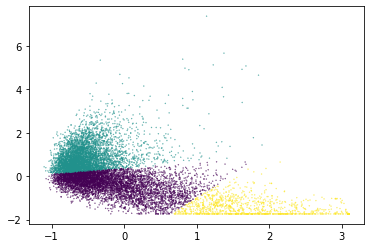

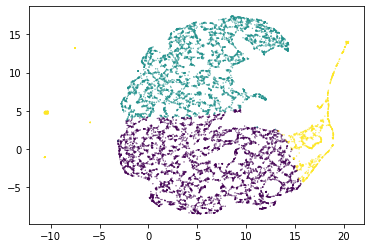

In [ ]:
kmeans_labels = cluster.KMeans(n_clusters=3).fit_predict(scaled_data)
plt.figure()
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=kmeans_labels, s=0.1, cmap='viridis')
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, s=0.1, cmap='viridis')
kmeans_clusters = sorted(Counter(kmeans_labels).items(), key=lambda x: x[1])
potential_users_kmeans = [user_ids[i] for i in range(n_users) if kmeans_labels[i] == kmeans_clusters[0][0]] ## smallest cluster
print(len(potential_users_kmeans))

Counter({1: 7715, 2: 3631, 0: 900})
900


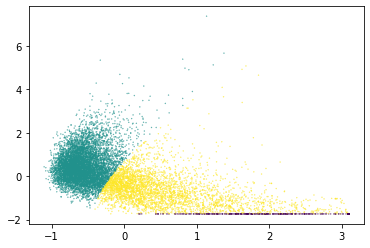

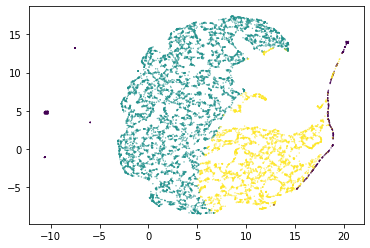

In [ ]:
gmm = mixture.GaussianMixture(n_components=3).fit(scaled_data)
gmm_labels = gmm.predict(scaled_data)
plt.figure()
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=gmm_labels, s=0.1, cmap='viridis')
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=gmm_labels, s=0.1, cmap='viridis')
gmm_clusters = sorted(Counter(gmm_labels).items(), key=lambda x: x[1])
print(Counter(gmm_labels))
potential_users_gmm = [user_ids[i] for i in range(n_users) if gmm_labels[i] == gmm_clusters[0][0]] ## smallest cluster
print(len(potential_users_gmm))

In [ ]:
potential_users = set(potential_users_kmeans).intersection(set(potential_users_gmm))
print(len(potential_users))

884


mean sentiment variance is 8.619034367079185e-07
mean sentence similarity is 0.969211601933725
mean sentiment variance of total tweets is 0.14793128587456372
mean sentence similarity of total tweets is 0.7722292055421365


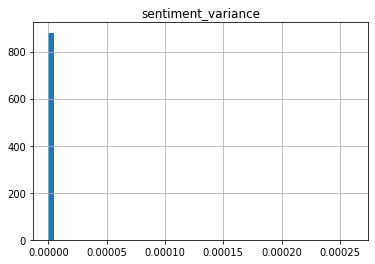

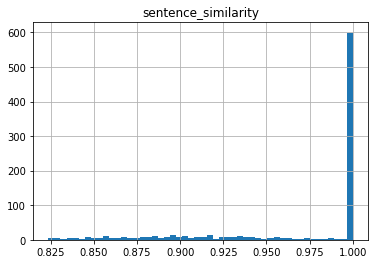

In [ ]:
tmp_df = accounts_df[accounts_df['user_id'].isin(potential_users)]
tmp_df.hist(column="sentiment_variance", bins=50)
tmp_df.hist(column="sentence_similarity", bins=50)

print(f"mean sentiment variance is {np.mean(tmp_df['sentiment_variance'].tolist())}")
print(f"mean sentence similarity is {np.mean(tmp_df['sentence_similarity'].tolist())}")

print(f"mean sentiment variance of total tweets is {np.mean(accounts_df['sentiment_variance'].tolist())}")
print(f"mean sentence similarity of total tweets is {np.mean(accounts_df['sentence_similarity'].tolist())}")

In [ ]:
for user in potential_users:
  print('\n'.join(accounts_dict[user][:5]))

?...

Absolutely DID NOT happen
Really took it to Twitter





3
Cero

Refer to him as 46. That is the percentage of the popular vote he received in both the 2016 and 2020 elections.

.
.



Positif Vibes



555555

.                             .
.                                  .       .
.               .                  .
.
.              .                 !





Its on the window sill...

120



How does one go about getting an Orb these days?

Wild


A longtime Employee has confirmed to me that the ROTHSCHILDs are able much more then 500 Trillions.Pure Satanism. They feed on the Blood and Hate of their Victims.
American Doctors Address COVID19 Misinformation with Capitol Hill Press...  via




Learned something new about the Bible in plain english!
so weird!!!! yes I think so...
22 is to close now
Has nothing to do with the 6,000 a day immigrants being bussed around the country unchecked





!    !     !

Vekedagar hjerne: kan sove litt til, sant? Jobben kan vente! Helgehjerne

In [ ]:
with open('bot detection/potential_bot_users.list', 'w') as f:
  for user in potential_users:
    f.write(f"{user}\n")